In [1]:
%matplotlib inline


# Stochastic Bornhuetter Ferguson


There are several aspects of the chainladder module that are demonstrated with
this example.

1. We see how to use the `BootstrapODPSample` and `BornhuetterFerguson` to come
  up with a stochastic view of the Bornhuetter-Ferguson method.
2. We use the `broadcast_axis` method of the triangle class (new in 0.4.7)




In [2]:
import numpy as np
import pandas as pd
import chainladder as cl

# Simulation parameters
random_state = 42
n_sims = 1000

# Get data
data = pd.read_csv('./data/mack.csv')
data.head()

,accident,development,paid
0,2011,2011,5946975
1,2012,2012,6346756
2,2013,2013,6269090
3,2014,2014,5863015
4,2015,2015,5778885


In [3]:
x = cl.Triangle(
    data=data.fillna(0), origin='accident', development='development', columns='paid').incr_to_cum()
x

,12,24,36,48,60,72,84,96,108,120
2011,"5,946,975","9,668,212","10,563,929","10,771,689","10,978,393","11,040,517","11,106,330","11,121,180","11,132,310","11,148,123"
2012,"6,346,756","9,593,162","10,316,384","10,468,181","10,536,005","10,572,608","10,625,360","10,636,546","10,648,192",
2013,"6,269,090","9,245,313","10,092,366","10,355,134","10,507,837","10,573,281","10,626,826","10,635,750",,
2014,"5,863,015","8,546,239","9,268,771","9,459,424","9,592,400","9,680,740","9,724,069",,,
2015,"5,778,885","8,524,114","9,178,008","9,451,403","9,681,691","9,786,915",,,,
2016,"6,184,793","9,013,131","9,585,896","9,830,795","9,935,752",,,,,
2017,"5,600,184","8,493,391","9,056,505","9,282,022",,,,,,
2018,"5,288,066","7,728,169","8,256,212",,,,,,,
2019,"5,290,793","7,648,729",,,,,,,,
2020,"5,675,568",,,,,,,,,


### Basic Chainladder

The basic chainladder method is entirely specified by its development pattern selections.  For this reason, the `Chainladder` estimator takes no additional assumptions, i.e. no additional arguments.

In [4]:
cl.MackChainladder()

MackChainladder()

In [5]:
mack_dev = cl.Pipeline(
    [('dev', cl.Development())
    ,('tail', cl.TailCurve())
    ]
).fit_transform(x)

In [6]:
mack_model = cl.MackChainladder().fit(mack_dev)

In [7]:
mack_model.ldf_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144
(All),1.4925,1.0778,1.0229,1.0148,1.0070,1.0051,1.0011,1.0010,1.0014,1.0003,1.0002


In [8]:
mack_model.ultimate_

,2262
2011,"11,153,713"
2012,"10,668,664"
2013,"10,667,353"
2014,"9,763,500"
2015,"9,877,167"
2016,"10,097,306"
2017,"9,572,940"
2018,"8,709,744"
2019,"8,696,329"
2020,"9,631,210"


In [9]:
np.sum(mack_model.ibnr_)

6096594.64664077

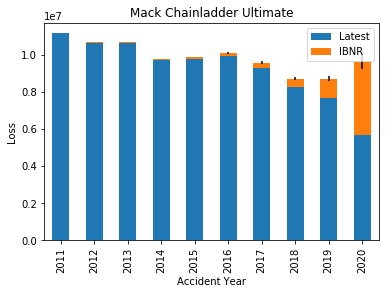

In [10]:
plot_data = mack_model.summary_.to_frame()
g = plot_data[['Latest', 'IBNR']] \
    .plot(kind='bar', stacked=True,
          yerr=pd.DataFrame({'latest': plot_data['Mack Std Err']*0,
                             'IBNR': plot_data['Mack Std Err']}),
          ylim=(0, None), title='Mack Chainladder Ultimate')
g.set_xlabel('Accident Year')
g.set_ylabel('Loss');

In [11]:
mack_model.summary_

,Latest,IBNR,Ultimate,Mack Std Err
2011,"11,148,123","5,590","11,153,713",620
2012,"10,648,192","20,472","10,668,664",935
2013,"10,635,750","31,603","10,667,353","1,280"
2014,"9,724,069","39,431","9,763,500","3,174"
2015,"9,786,915","90,252","9,877,167","7,678"
2016,"9,935,752","161,554","10,097,306","33,369"
2017,"9,282,022","290,918","9,572,940","73,508"
2018,"8,256,212","453,532","8,709,744","85,445"
2019,"7,648,729","1,047,600","8,696,329","134,406"
2020,"5,675,568","3,955,642","9,631,210","411,024"


# Stochastic Bornhuetter Ferguson


There are several aspects of the chainladder module that are demonstrated with
this example.

1. We see how to use the `BootstrapODPSample` and `BornhuetterFerguson` to come
  up with a stochastic view of the Bornhuetter-Ferguson method.
2. We use the `broadcast_axis` method of the triangle class (new in 0.4.7)

In [20]:
mu = np.array([11653101,11367306,10962965,10616762,11044881,11480700,11413572,11126527,10986548,11618437])
premium = x.latest_diagonal*0 + np.reshape(mu, x.latest_diagonal.shape)
premium

,2020
2011,"11,653,101"
2012,"11,367,306"
2013,"10,962,965"
2014,"10,616,762"
2015,"11,044,881"
2016,"11,480,700"
2017,"11,413,572"
2018,"11,126,527"
2019,"10,986,548"
2020,"11,618,437"


In [21]:
# Simulate loss triangles
sim = cl.BootstrapODPSample(random_state=random_state, n_sims=n_sims)
sim.fit(x, sample_weight=premium)

BootstrapODPSample(drop=None, drop_high=None, drop_low=None,
                   drop_valuation=None, hat_adj=True, n_periods=-1, n_sims=1000,
                   random_state=42)

In [22]:
# Fit Bornhuetter-Ferguson to stochastically generated data
model = cl.BornhuetterFerguson(1.0, apriori_sigma=0.0)
model.fit(sim.resampled_triangles_, sample_weight=premium)

BornhuetterFerguson(apriori=1.0, apriori_sigma=0.0, random_state=None)

In [23]:
ibnr = model.ibnr_.sum('origin')

In [24]:
ibnr.mean()

7349919.419963395

In [25]:
model.ibnr_.mean()

/Users/holmen1/opt/anaconda3/lib/python3.7/site-packages/chainladder/core/pandas.py:280: RuntimeWarning: Mean of empty slice
  obj.values = func(obj.values, axis=axis, *args, **kwargs)


,2262
2011,
2012,"15,862"
2013,"26,763"
2014,"37,191"
2015,"95,025"
2016,"177,605"
2017,"341,119"
2018,"574,070"
2019,"1,315,978"
2020,"4,766,306"


In [26]:
model.ibnr_.std()

/Users/holmen1/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


,2262
2011,
2012,"16,183"
2013,"18,302"
2014,"19,169"
2015,"24,180"
2016,"29,206"
2017,"35,704"
2018,"40,639"
2019,"53,722"
2020,"77,381"


[]

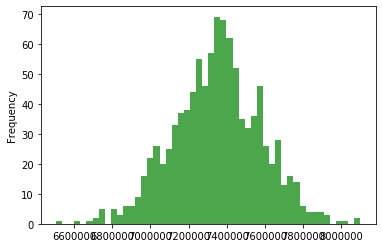

In [27]:
ibnr.plot(kind='hist', bins=50, alpha=0.7, color='green').plot()

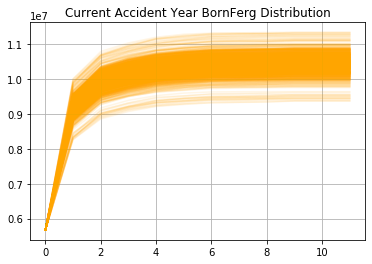

In [28]:
# Grab completed triangle replacing simulated known data with actual known data
full_triangle = model.full_triangle_ - model.X_ + \
                x.broadcast_axis('index', sim.resampled_triangles_.index)

# Limiting to the current year for plotting
current_year = full_triangle[full_triangle.origin==full_triangle.origin.max()].to_frame().T

# Plot the data
current_year.reset_index(drop=True).plot(
    color='orange', legend=False, alpha=0.1,
    title='Current Accident Year BornFerg Distribution', grid=True);

In [29]:
full_triangle.shape

(1000, 1, 10, 12)